# Sonata Lightning Tools: Query Similarity Analyzer

### Takes the query data from the Reports and provides similarity matrix. Helps in developers in analyzing the reports and reuse the aspects of reports

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import os
%run lightning_helper.ipynb

## Document metadata with Queries

In [2]:
# Load the data from Excel file
excel_file_path = get_full_file_path('input', 'document-query-plan.csv')
# excel_file_path = 'test_data.csv'
df = pd.read_csv(excel_file_path)

## Read all the query statements & clense queries

In [3]:
def add_statement_column(row):
    data = json.loads(row['QueryPlan'])
    
    if "queryplan" in data:
        if "statement" in data["queryplan"]:
            return json.dumps(data["queryplan"]["statement"])
        elif "multipleflows" in data["queryplan"] and "statement" in data["queryplan"]["multipleflows"]:
            return json.dumps(data["queryplan"]["multipleflows"]["statement"])

    return json.dumps(data) 

In [4]:
df["Query_Statement"] = df.apply(add_statement_column, axis=1)

In [5]:
# Cache the data 
# data_file_path = get_full_file_path('output', 'query_data_lookup.csv')
# df.to_csv(data_file_path)

## Create cosine similarity matrix of all the quries

In [6]:
# Convert queryplan column to bag-of-words vectors
vectorizer = CountVectorizer()
queryplan_vectors = vectorizer.fit_transform(df["Query_Statement"])

# Calculate cosine similarity between queryplan vectors
cosine_sim = cosine_similarity(queryplan_vectors)

In [8]:
# Cache the data
# sim_file_path = get_full_file_path('output', 'query_data_similarity.csv')
# np.savetxt(sim_file_path, cosine_sim, delimiter=",")

## Similarity heatmap for all the reports based on Query statements

In [14]:
print(cosine_sim)

[[1.         0.88492108 0.87751303 0.04793059 0.01923549 0.77877994
  0.73680309 0.89220451 0.01923549 0.06062549]
 [0.88492108 1.         0.92041095 0.07265861 0.02211249 0.82639387
  0.80327115 0.90166963 0.02211249 0.0857761 ]
 [0.87751303 0.92041095 1.         0.03843795 0.01169798 0.79629199
  0.83856308 0.80494154 0.01169798 0.04537738]
 [0.04793059 0.07265861 0.03843795 1.         0.030403   0.12309149
  0.05264484 0.0805823  0.030403   0.09965563]
 [0.01923549 0.02211249 0.01169798 0.030403   1.         0.04116586
  0.01344471 0.03065492 1.         0.17945919]
 [0.77877994 0.82639387 0.79629199 0.12309149 0.04116586 1.
  0.76465553 0.84559432 0.04116586 0.0934161 ]
 [0.73680309 0.80327115 0.83856308 0.05264484 0.01344471 0.76465553
  1.         0.69042487 0.01344471 0.0423744 ]
 [0.89220451 0.90166963 0.80494154 0.0805823  0.03065492 0.84559432
  0.69042487 1.         0.03065492 0.10107594]
 [0.01923549 0.02211249 0.01169798 0.030403   1.         0.04116586
  0.01344471 0.03065

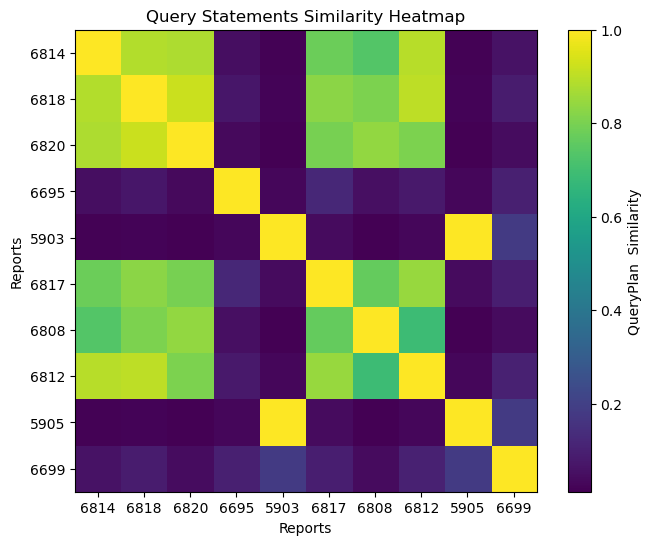

In [10]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cosine_sim, cmap='viridis', interpolation='nearest')
plt.colorbar(label='QueryPlan  Similarity')
plt.title('Query Statements Similarity Heatmap')
plt.xlabel('Reports')
plt.ylabel('Reports')
plt.xticks(range(len(cosine_sim)), df['DocId'])
plt.yticks(range(len(cosine_sim)),  df['DocId'])
plt.show()

In [11]:
# Index of the specific record you want to match
row_index_of_report = 4  # Replace this with the desired index

# Get matching rows from the DataFrame
matching_row = df.loc[row_index_of_report]

matching_row

DocId                                                           5903
DpId                                                             DP0
DpName                                                       Query 1
DsId                                                            5636
QueryPlan          {"queryplan":{"@custom":"false","@editable":"t...
TableCount                                                         3
ColumnCount                                                        8
Complexity                                                      True
TableList          Article_Color_Lookup;Article_Lookup_Criteria;S...
ColumnList         Family_name;Category;Article_id;Article_label;...
Query_Statement    {"queryplan": {"@custom": "false", "@editable"...
Name: 4, dtype: object

In [12]:
# Threshold for similarity
threshold = 0.8

In [13]:
# Get the row of the specific record from the similarity matrix
specific_record_similarity = cosine_sim[row_index_of_report]

# Find rows with similarity above the threshold
matching_indices = np.where(specific_record_similarity > threshold)[0]

# Print matching indices
print("Matching indices:", matching_indices)

# Get matching rows from the DataFrame
matching_rows = df.loc[matching_indices]

# Print matching rows
print("Matching rows:")
print(matching_rows)

Matching indices: [4 8]
Matching rows:
   DocId DpId   DpName  DsId  \
4   5903  DP0  Query 1  5636   
8   5905  DP0  Query 1  5636   

                                           QueryPlan  TableCount  ColumnCount  \
4  {"queryplan":{"@custom":"false","@editable":"t...           3            8   
8  {"queryplan":{"@custom":"false","@editable":"t...           3            8   

   Complexity                                          TableList  \
4        True  Article_Color_Lookup;Article_Lookup_Criteria;S...   
8        True  Article_Color_Lookup;Article_Lookup_Criteria;S...   

                                          ColumnList  \
4  Family_name;Category;Article_id;Article_label;...   
8  Family_name;Category;Article_id;Article_label;...   

                                     Query_Statement  
4  {"queryplan": {"@custom": "false", "@editable"...  
8  {"queryplan": {"@custom": "false", "@editable"...  
